In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [85]:
import pandas as pd
import datetime

weather = pd.read_csv('dataset/weather_in_Antwerp_cleaned.csv')
power_info = pd.read_csv('dataset/PV_Elec_Gas3.csv')
power_info.head()
weather.head()

,slno,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


# **Let's clean solar power table first:**

In [86]:
power_info = power_info[['date','Cumulative_solar_power']]
# power_info = power_info.rename(columns= {'date'})
power_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3304 non-null   object 
 1   Cumulative_solar_power  3304 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.8+ KB


In [87]:
# power_info=test

In [88]:
display(power_info[power_info.date=='11/01/2012'])
test=power_info

power_info.date = pd.to_datetime(power_info.date)

power_info.set_index(['date'], inplace=True)
# display(power_info[power_info.date=='11/01/2012'])
display(power_info.loc['2012-11-01'])







,date,Cumulative_solar_power
77,11/01/2012,248.3


C:\Users\ariel\AppData\Local\Temp\ipykernel_12504\2318442736.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  power_info.date = pd.to_datetime(power_info.date)


Cumulative_solar_power    3979.1
Name: 2012-11-01 00:00:00, dtype: float64

In [89]:
# power_info.date = pd.to_datetime(power_info.date)

    
power_info.head()

,Cumulative_solar_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


In [90]:
# power_info = power_info.shift(periods=-1, freq='D', axis=0)   #Correcting the measure error
                                                        # (mentioned in Frank's data description)
#####CUMULATIVE to DAILY*******************
temp = power_info.shift(periods=1, fill_value=0, axis=0)
power_info['day_power'] = power_info.loc[:, 'Cumulative_solar_power'] - temp.loc[:, 'Cumulative_solar_power']
power_info.drop(['Cumulative_solar_power'], axis=1, inplace=True)
power_info.day_power.iloc[0] = 5
power_info.head()

C:\Users\ariel\AppData\Local\Temp\ipykernel_12504\3699455481.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  power_info.day_power.iloc[0] = 5


,day_power
date,
2011-10-26,5.0
2011-10-27,10.1
2011-10-28,10.0
2011-10-29,9.4
2011-10-30,4.6


In [91]:
# import seaborn as sns
# from matplotlib import pyplot as plt

# sns.set()
# # power_index= power_info.reset_index()
# power_info.plot(kind='line', x='date', y='Cumulative_solar_power', figsize=(15,5))

# plt.title('Daily Power Produced By Solar Panels')
# plt.ylabel('Daily Power')
# plt.show()

# **To clean weather table now:**

In [92]:
def clear_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h', '')
    return obj
def trans_from_objects(weather):
    if 'slno' in weather.columns:
        weather.drop(['slno'], axis=1, inplace=True)
    
    #try statement is here for the future weather, 
    #as it is without barometer on the site
    try:
        weather.barometer = weather.barometer.apply(lambda x: x.replace(' mbar', '') 
                                    if isinstance(x, str) else x).astype(float)
        weather.drop(['visibility'], axis =1, inplace=True)
    except AttributeError:
        pass
    
    weather.humidity = weather.humidity.apply(lambda x: x.replace('%', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.temp = weather.temp.apply(lambda x: x.replace('°C', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.wind = weather.wind.apply(clear_wind).astype(float)
    
    return weather

#transfer dataframe from objects dtype to numbers
weather_tran = trans_from_objects(weather)
weather_tran.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
0,00:20,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012,1,1
1,00:50,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012,1,1
2,01:50,12.0,Overcast.,19.0,88.0,1011.0,2012,1,1
3,02:20,12.0,Partly cloudy.,17.0,88.0,1010.0,2012,1,1
4,02:50,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012,1,1


In [93]:
weather_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133669 entries, 0 to 133668
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   clock      133669 non-null  object 
 1   temp       133650 non-null  float64
 2   weather    133666 non-null  object 
 3   wind       133623 non-null  float64
 4   humidity   133321 non-null  float64
 5   barometer  133655 non-null  float64
 6   year       133669 non-null  int64  
 7   month      133669 non-null  int64  
 8   day        133669 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 9.2+ MB


In [94]:
#Form the date column 
def create_date(weather):    
    weather['date'] = weather.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day} {row.clock}', axis=1)
    weather.date = pd.to_datetime(weather.date)
    return weather.drop(['clock', 'year', 'month', 'day'], axis = 1)

weather_pretty = create_date(weather_tran)
weather_pretty.head()

,temp,weather,wind,humidity,barometer,date
0,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012-01-01 00:20:00
1,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012-01-01 00:50:00
2,12.0,Overcast.,19.0,88.0,1011.0,2012-01-01 01:50:00
3,12.0,Partly cloudy.,17.0,88.0,1010.0,2012-01-01 02:20:00
4,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012-01-01 02:50:00


In [95]:
#to take the average of each day, so we have daily weather. Because we have the daily cum_power not hourly
def take_average_weather(weather, future = False):
    if future == False:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity', 'barometer',
                                              'date'])
    else:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity','date'])
    
    temp, wind, humidity, barometer, counter= [0]*5
    for i in range(len(weather)):
        if future == False:
            if (weather.loc[i, 'date'].time() ==datetime.time(0, 20)) and (i!=0):
                new_row = pd.DataFrame({
                    'temp': [temp/counter],
                    'wind': [wind/counter],
                    'humidity': [humidity/counter],
                    'barometer': [barometer/counter],
                    'date': [pd.to_datetime(weather.loc[i-1, 'date'].date())],
                    'weather': [weath]
                })
                average_weather = pd.concat([average_weather, new_row], ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5

            #Here we'll take the weather status in the most powerful hour (15:20), because you can't take averge 
                                                                                                        #here.
            if (weather.loc[i, 'date'].time()==datetime.time(15,20)):
                weath = weather.loc[i, 'weather']
        else:
            # or i==len(weather)-1 , so the last day in the data been appended
            if ((weather.loc[i, 'date'].time() ==datetime.time(0, 0)) and (i!=0)) or (i==len(weather)-1):
                new_row = pd.DataFrame({
                    'temp': [temp/counter],
                    'wind': [wind/counter],
                    'humidity': [humidity/counter],
                    'date': [pd.to_datetime(weather.loc[i-1, 'date'].date())],
                    'weather': [weath]
                })
                average_weather = pd.concat([average_weather, new_row], ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5

            #Here we'll take the weather status in the most powerful hour (15:20),
            #because you can't take averge with categories.
            if (weather.loc[i, 'date'].time()==datetime.time(15,0)):
                weath = weather.loc[i, 'weather']
        counter += 1
        temp += weather.loc[i, 'temp']
        wind += weather.loc[i, 'wind']
        humidity += weather.loc[i, 'humidity']
        if future == False:
            barometer += weather.loc[i, 'barometer']
        
    return average_weather
average_weather = take_average_weather(weather_pretty)

C:\Users\ariel\AppData\Local\Temp\ipykernel_12504\6124821.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  average_weather = pd.concat([average_weather, new_row], ignore_index=True)


In [96]:
def merge_weatherANDpower():
    dataset = average_weather.merge(power_info, on=['date'])
    return dataset.set_index('date')
final_dataset = merge_weatherANDpower()
final_dataset.head()

,temp,weather,wind,humidity,barometer,day_power
date,,,,,,
2012-01-01,12.333333,Overcast.,21.333333,89.333333,1007.866667,0.5
2012-01-02,7.787234,Scattered clouds.,17.212766,81.425532,1009.170213,0.8
2012-01-03,8.208333,Light rain. Fog.,32.354167,78.229167,1007.916667,2.9
2012-01-04,7.354167,Broken clouds.,26.375000,71.041667,1012.687500,0.8
2012-01-05,8.292683,Rain showers. Broken clouds.,39.170732,77.804878,998.219512,2.7


In [97]:
final_dataset.head(15)

,temp,weather,wind,humidity,barometer,day_power
date,,,,,,
2012-01-01,12.333333,Overcast.,21.333333,89.333333,1007.866667,0.5
2012-01-02,7.787234,Scattered clouds.,17.212766,81.425532,1009.170213,0.8
2012-01-03,8.208333,Light rain. Fog.,32.354167,78.229167,1007.916667,2.9
2012-01-04,7.354167,Broken clouds.,26.375000,71.041667,1012.687500,0.8
2012-01-05,8.292683,Rain showers. Broken clouds.,39.170732,77.804878,998.219512,2.7
2012-01-06,6.291667,Partly sunny.,26.000000,76.833333,1019.333333,1.6
2012-01-07,7.958333,Passing clouds.,25.312500,77.479167,1018.312500,1.0
2012-01-08,7.456522,Passing clouds.,17.456522,77.956522,1023.282609,4.1
2012-01-09,8.434783,Partly sunny.,14.065217,85.543478,1027.913043,5.2


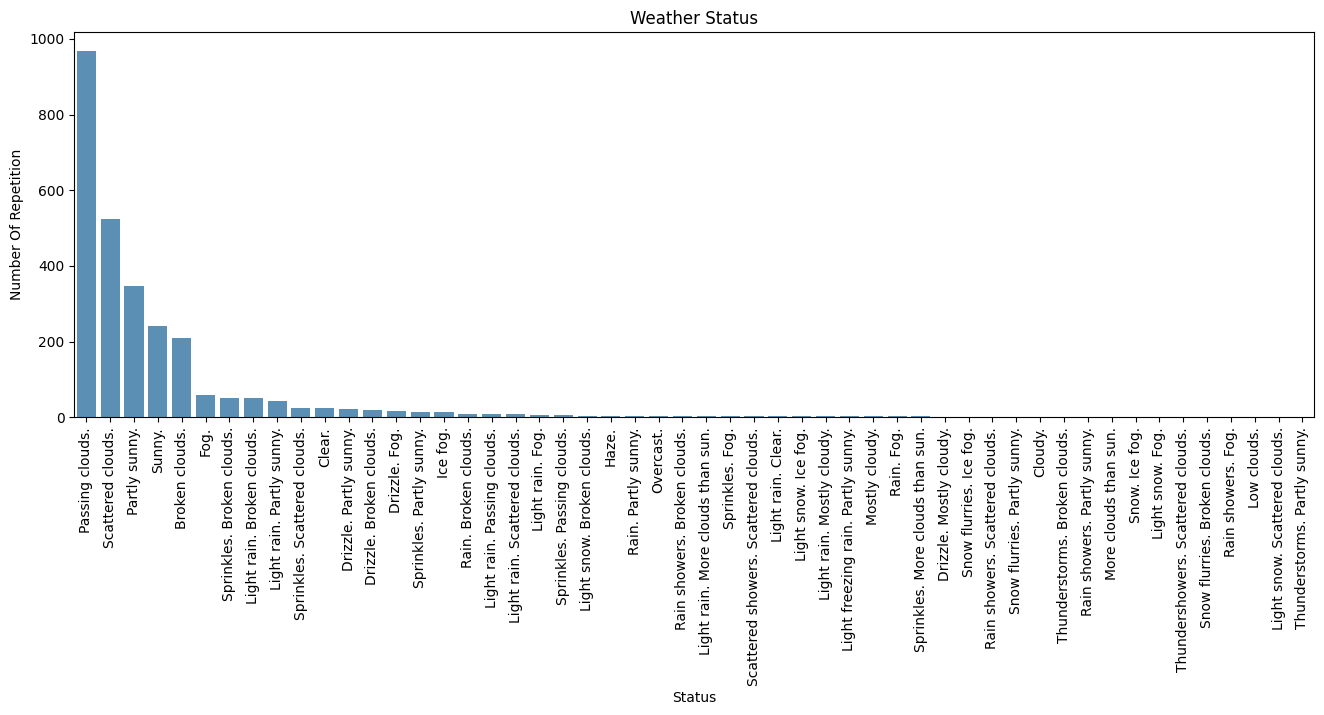

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt


weather_counts = final_dataset.weather.value_counts()
plt.figure(figsize=(16,5))
sns.barplot(x=weather_counts.index, y=weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show() # WHAT THE HECK! Let's reduce this amount of redundant information

In [99]:
#I need this, so I can deal with "loc"
final_dataset = final_dataset.reset_index()

def reduce_categories(weather):
    #Delete all first parts of two-part status, and highligh only the necessary categories. 
    #why the first part? Because we don't care about the raining or snowing weather, we care more about 
    #status of clouds
    for i in range(len(weather)):
        weather_list = weather.loc[i, 'weather'].split('.')
        if len(weather_list) > 2:
            weather.loc[i,'weather'] = weather_list[1].strip()
        elif len(weather_list) ==2:
            weather.loc[i, 'weather'] = weather_list[0].strip()

    weather.weather = weather.weather.map({
        'Ice fog':'Fog',
        'Haze':'Fog',
        'Fog':'Fog',
        'Clear':'Sunny',
        'Sunny':'Sunny',
        'Broken clouds':'Scattered clouds',
        'Scattered clouds':'Scattered clouds',
        'Overcast':'Cloudy',
        'More clouds than sun':'Cloudy',
        'More sun than clouds':'Sunny',
        'Low clouds':'Cloudy',
        'Mostly cloudy':'Cloudy',
        'Cloudy':'Cloudy',
        'Passing clouds':'Passing clouds',
        'Partly sunny':'Partly sunny',
        'Mostly sunny':'Sunny'
    },na_action='ignore')
    return weather
final_dataset = reduce_categories(final_dataset)

#get the index back to "date"
final_dataset.set_index('date', inplace=True)


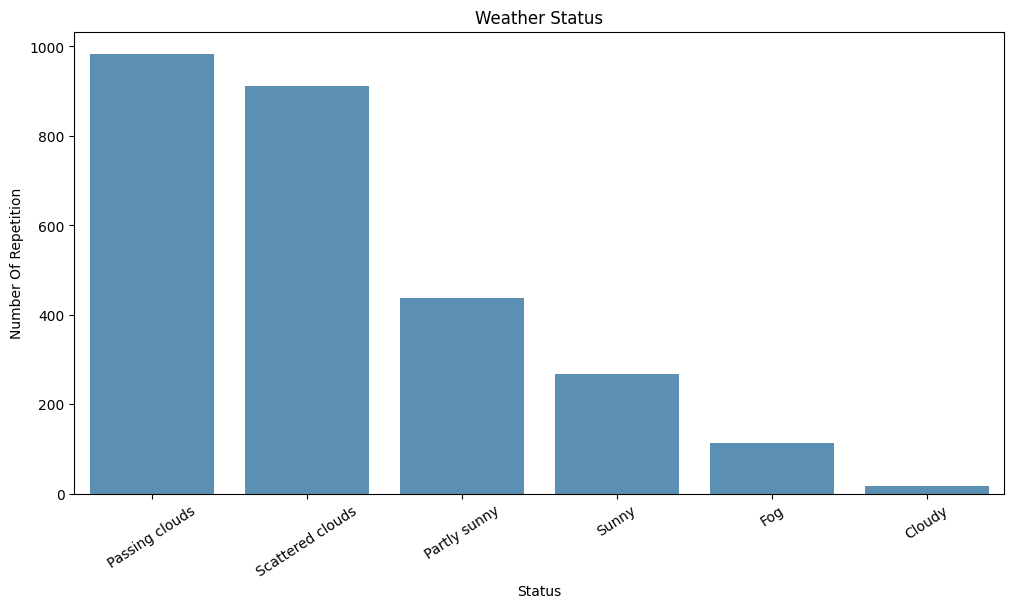

In [100]:
from matplotlib import pyplot as plt
final_dataset.weather.value_counts()
weather_counts = final_dataset.weather.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=weather_counts.index, y=weather_counts.values, alpha=0.8)
plt.xticks(rotation=33)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [101]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2731 entries, 2012-01-01 to 2019-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       2726 non-null   float64
 1   weather    2731 non-null   object 
 2   wind       2718 non-null   float64
 3   humidity   2708 non-null   float64
 4   barometer  2726 non-null   float64
 5   day_power  2731 non-null   float64
dtypes: float64(5), object(1)
memory usage: 149.4+ KB


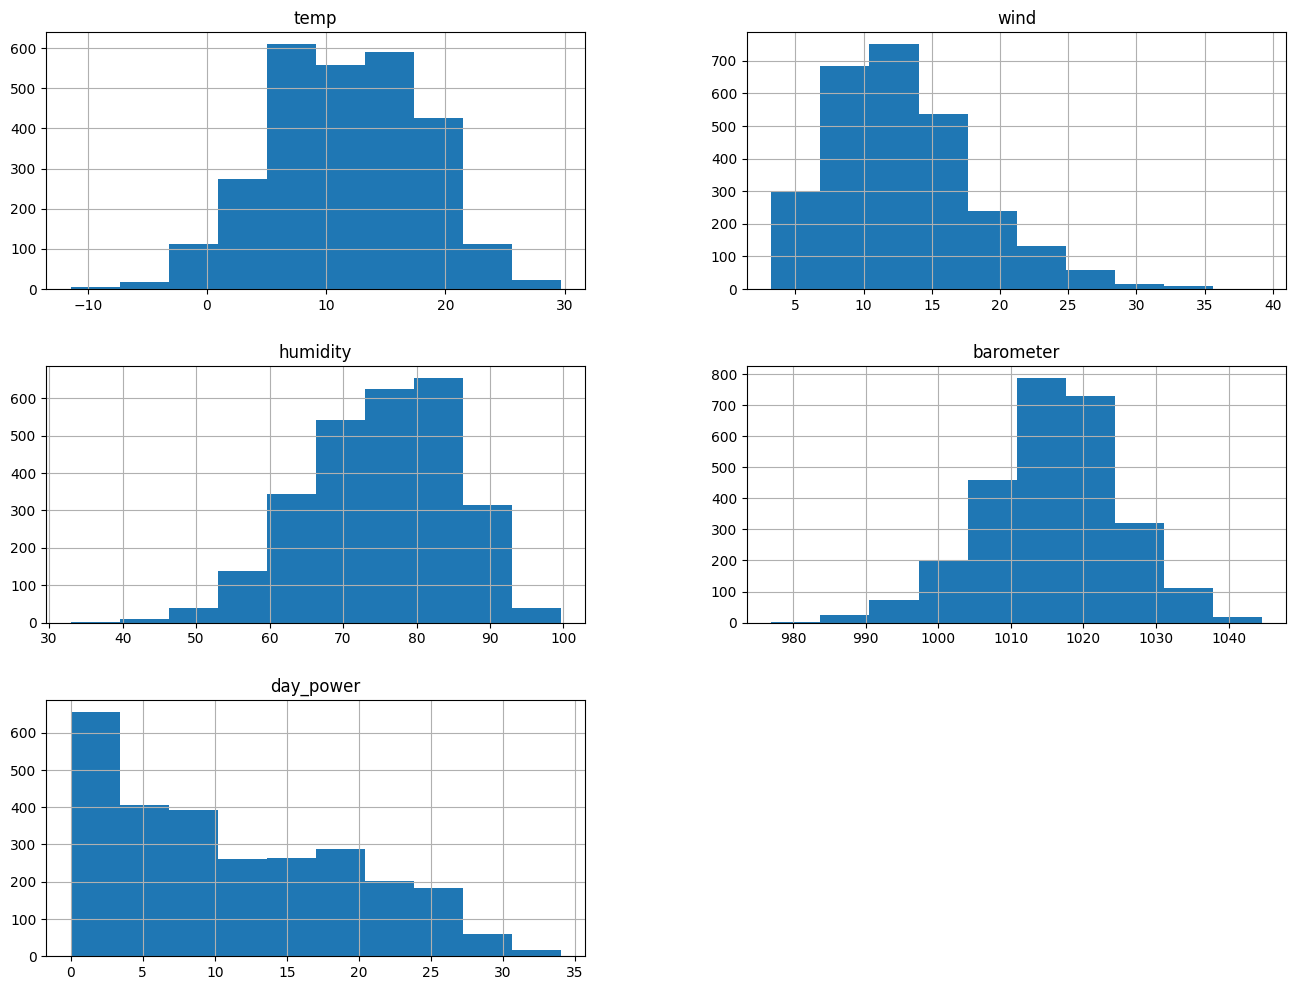

In [102]:
final_dataset.hist(figsize=(16,12))
plt.show()

# Training The Machine Learning Model

In [103]:
from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(final_dataset, test_size=0.2, 
                                                   random_state=42) 
df = train_set.copy() 
df.describe() 

,temp,wind,humidity,barometer,day_power
count,2180.000000,2173.000000,2165.000000,2180.000000,2184.000000
mean,11.474390,12.921205,75.403274,1015.556859,10.969505
std,6.343690,5.356622,10.004430,9.482471,8.212647
min,-11.437500,3.250000,32.914894,977.041667,0.000000
25%,6.706782,9.000000,68.239130,1009.952460,4.000000
50%,11.375000,12.063830,76.416667,1015.850000,9.500000
75%,16.470855,16.063830,83.108696,1021.752717,17.000000
max,29.680851,39.170732,98.000000,1044.541667,34.000000


In [104]:
df.corr() 

ValueError: could not convert string to float: 'Scattered clouds'

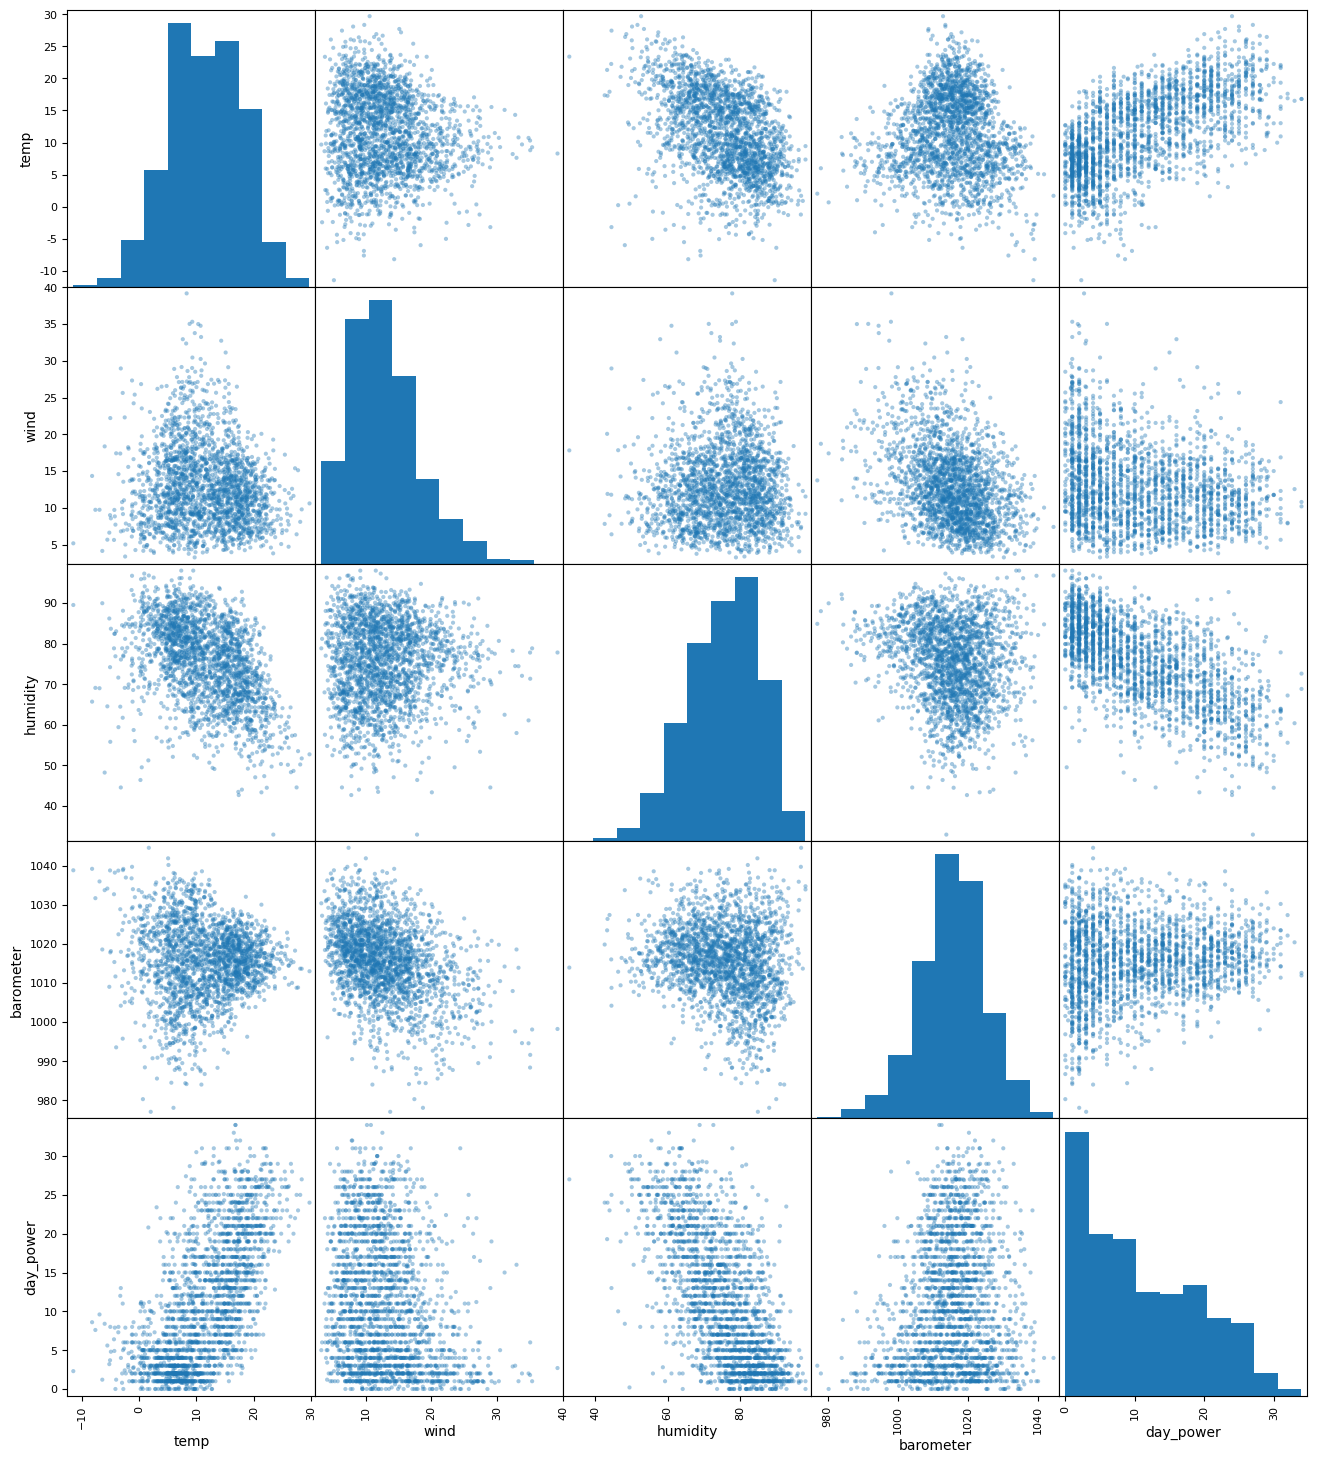

In [105]:
from pandas.plotting import scatter_matrix 
scatter_matrix(df, figsize=(16,18), alpha=0.4) 
plt.show()

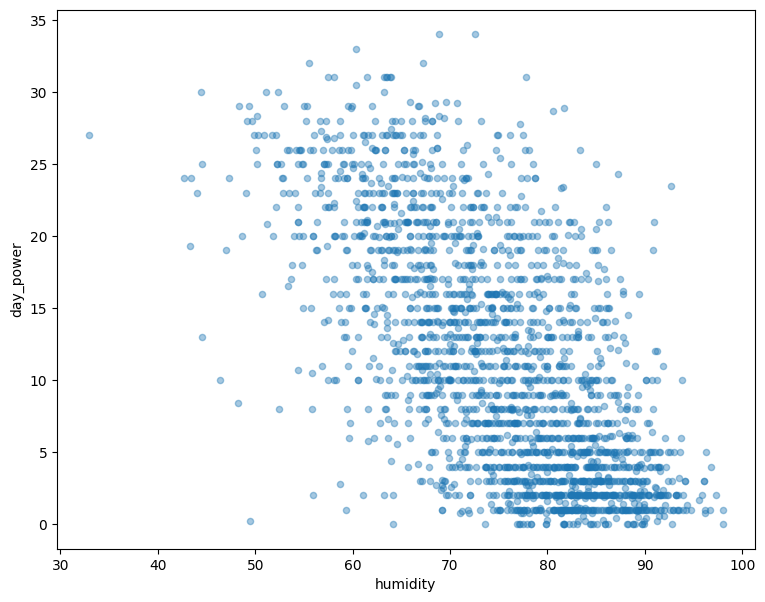

In [106]:
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

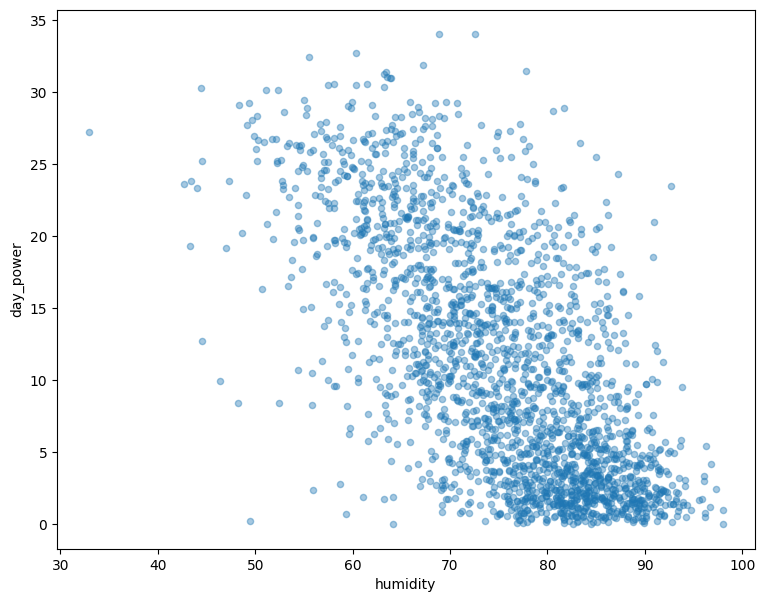

In [107]:
#To delete data anomalies
import random
df.day_power = df.day_power.apply(lambda x: x+random.randint(0,50)/100 if x==0 else x)
for i in range(1,34):
    df.day_power = df.day_power.apply(lambda x: x+random.randint(-50,50)/100 if x==i else x)
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

In [108]:
#As we have data (which we want to predict), without barometer column
features = df.drop(['day_power', 'barometer'], axis=1) 
columns=features.columns 
labels = df['day_power'].copy() 
features.head() 

,temp,weather,wind,humidity
date,,,,
2013-01-01,7.166667,Scattered clouds,19.312500,83.854167
2017-05-22,18.291667,Passing clouds,7.145833,55.270833
2015-03-15,5.595745,Scattered clouds,14.021277,80.468085
2018-02-18,0.377778,Passing clouds,6.377778,84.355556
2015-02-03,1.723404,Passing clouds,8.404255,83.553191


In [109]:
num_attr = list(features.drop(['weather'],axis=1)) 
cat_attr = ['weather'] 

In [110]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler 


num_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()) 
]) 

cat_pipeline = Pipeline([ 
    ('encoder', OneHotEncoder()) 
]) 

full_pipeline = ColumnTransformer([ 
    ('num_pipeline', num_pipeline, num_attr),
    ('cat_pipeline', cat_pipeline, cat_attr) 
]) 

In [111]:
prepared_features = full_pipeline.fit_transform(features) 

In [113]:
import numpy as np 

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import cross_val_score  

lin_reg = LinearRegression() 
lin_reg.fit(prepared_features, labels) 
y_predicted = lin_reg.predict(prepared_features) 
scores = cross_val_score(lin_reg, prepared_features, labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

5.166333323393134

0.30759977096136615

In [114]:
test = test_set.copy()
test_features = test.drop(['day_power', 'barometer'], axis=1) 
test_labels = test['day_power'].copy() 

In [115]:
prepared_test = full_pipeline.transform(test_features) 
test_predicted = lin_reg.predict(prepared_test)

In [116]:
scores = cross_val_score(lin_reg, prepared_test, test_labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

5.537461821302583

0.5836545993477894

In [117]:
#Visualizing the difference between predicted and real values of day power for the test set

avg=[]
labels_avg = []
for i in range(len(test_labels)):
    avg.append(test_labels[i])
    if i % 40 == 0:
        labels_avg.append(np.array(avg).mean())
        avg.clear()
avg=[]
pred_avg = []
for i in range(len(test_predicted)):
    avg.append(test_predicted[i])
    if i % 40 == 0:
        pred_avg.append(np.array(avg).mean())
        avg.clear()

C:\Users\ariel\AppData\Local\Temp\ipykernel_12504\3725207817.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg.append(test_labels[i])


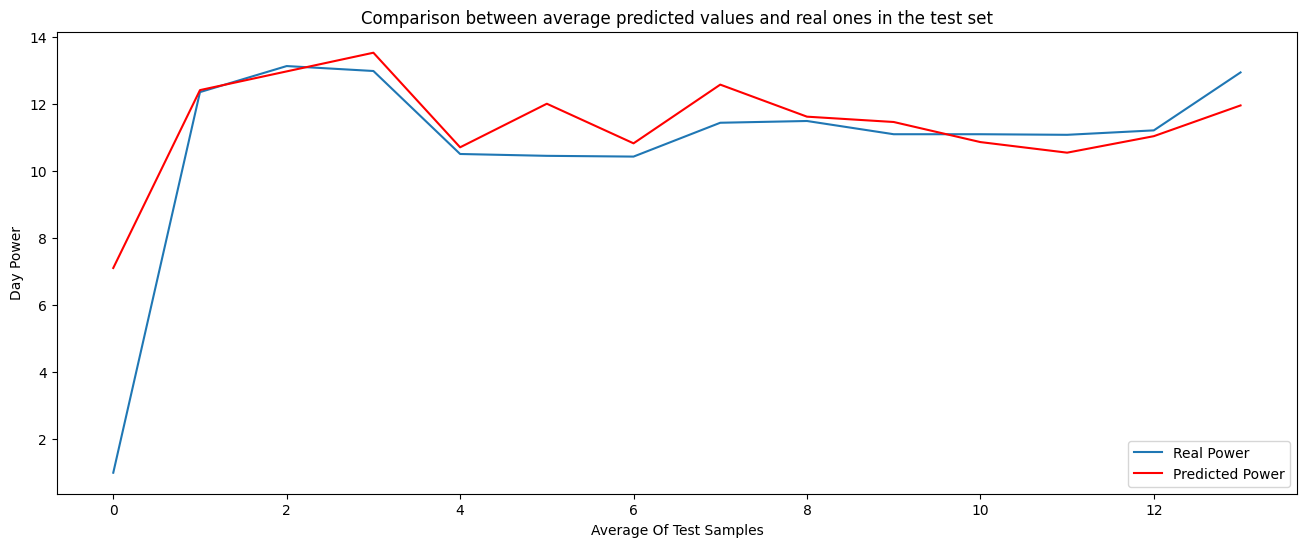

In [118]:
plt.figure(figsize=(16,6))
plt.plot(range(len(labels_avg)), labels_avg)
plt.plot(range(len(pred_avg)), pred_avg, 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

In [119]:
weather_future= pd.read_csv('dataset/output_future.csv')

weather_future.head()

,slno,clock,temp,weather,wind,humidity,year,month,day
0,0,00:00,21 °C,Passing clouds.,13 km/h,62%,2020,8,22
1,1,01:00,20 °C,Passing clouds.,14 km/h,69%,2020,8,22
2,2,02:00,19 °C,Passing clouds.,15 km/h,73%,2020,8,22
3,3,03:00,19 °C,Passing clouds.,15 km/h,75%,2020,8,22
4,4,04:00,18 °C,Passing clouds.,15 km/h,76%,2020,8,22


In [120]:
weather_future.info()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   slno      144 non-null    int64 
 1   clock     144 non-null    object
 2   temp      144 non-null    object
 3   weather   144 non-null    object
 4   wind      144 non-null    object
 5   humidity  144 non-null    object
 6   year      144 non-null    int64 
 7   month     144 non-null    int64 
 8   day       144 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 10.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133669 entries, 0 to 133668
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   clock      133669 non-null  object        
 1   temp       133650 non-null  float64       
 2   weather    133666 non-null  object        
 3   wind       133623 non-null  float64       
 4   humidity   133321 non-n

In [125]:
weather.columns

Index(['clock', 'temp', 'weather', 'wind', 'humidity', 'barometer', 'year',
       'month', 'day', 'date'],
      dtype='object')

In [121]:
weather_future.drop(['slno'], axis=1, inplace=True)

In [122]:
def predict_future_data(data):
    tran_fut = trans_from_objects(data)
    tran_fut = create_date(tran_fut)
    avg_fut = take_average_weather(tran_fut, future=True)
    red_fut = reduce_categories(avg_fut)
    red_fut = red_fut.set_index('date')
    prepared_future = full_pipeline.transform(red_fut)
    return red_fut.index, lin_reg.predict(prepared_future)

date, predicted_data = predict_future_data(weather_future)

C:\Users\ariel\AppData\Local\Temp\ipykernel_12504\6124821.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  average_weather = pd.concat([average_weather, new_row], ignore_index=True)


In [138]:
# Take a single row from the weather_future dataframe
single_row = weather_future.iloc[[10]].copy()

# Use the predict_future_data function to predict the power generated
date, predicted_power = predict_future_data(single_row)

# Print the predicted power
print("Predicted power generated:", predicted_power)


KeyError: 0

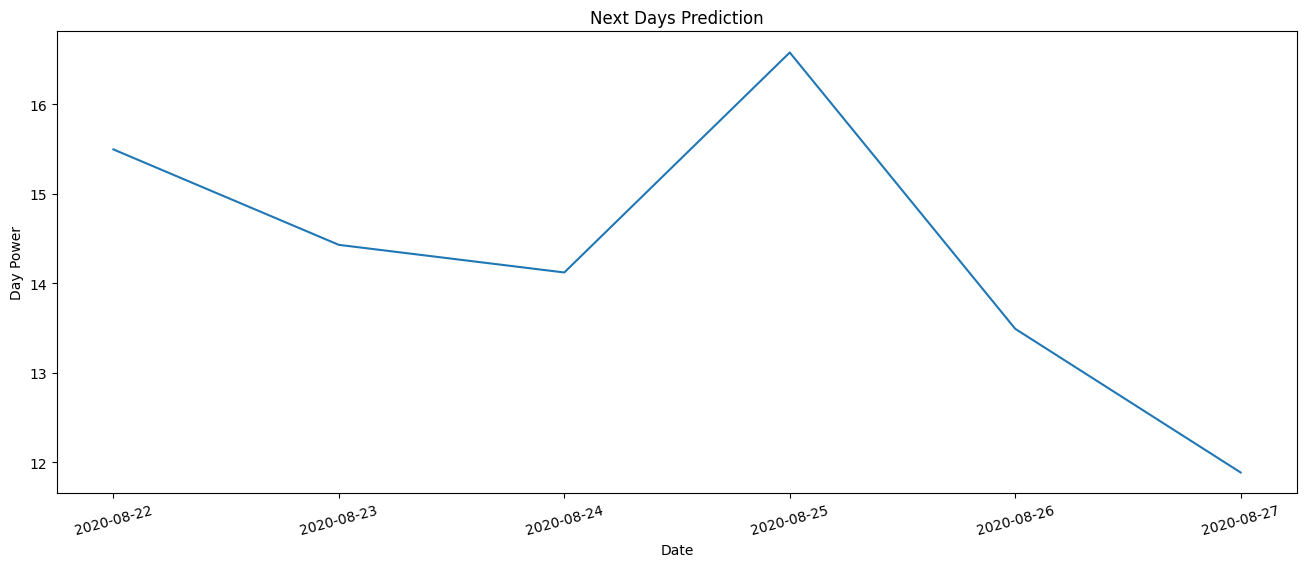

In [123]:
plt.figure(figsize=(16,6))
plt.plot(date,predicted_data)
plt.title('Next Days Prediction')
plt.ylabel('Day Power')
plt.xlabel('Date')
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xticks(rotation=15)
plt.show()

In [126]:
# dummy data for pridiction
# [ 'temp', 'weather', 'wind', 'humidity', 'year','month', 'day']
dummy=[
    [ 10, 'Sunny', 10, 50, 2020, 5, 1],
    [ 20, 'Sunny', 10, 50, 2020, 5, 2],
    [ 30, 'Sunny', 10, 50, 2020, 5, 3],
    [ 40, 'Sunny', 10, 50, 2020, 5, 4],
    [ 50, 'Sunny', 10, 50, 2020, 5, 5],
    [ 60, 'Sunny', 10, 50, 2020, 5, 6],
    [ 70, 'Sunny', 10, 50, 2020, 5, 7],
    [ 80, 'Sunny', 10, 50, 2020, 5, 8],
    [ 90, 'Sunny', 10, 50, 2020, 5, 9],
    [ 100, 'Sunny', 10, 50, 2020, 5, 10],
    [ 110, 'Sunny', 10, 50, 2020, 5, 11],
    [ 120, 'Sunny', 10, 50, 2020, 5, 12],
    [ 130, 'Sunny', 10, 50, 2020, 5, 13],
    [ 140, 'Sunny', 10, 50, 2020, 5, 14],
    [ 150, 'Sunny', 10, 50, 2020, 5, 15],
    [ 160, 'Sunny', 10, 50, 2020, 5, 16],
    [ 170, 'Sunny', 10, 50, 2020, 5, 17],
    [ 180, 'Sunny', 10, 50, 2020, 5, 18],
    [ 190, 'Sunny', 10, 50, 2020, 5, 19],
    [ 200, 'Sunny', 10, 50, 2020, 5, 20],
]

dummy_df = pd.DataFrame(dummy)
dummy_df

,0,1,2,3,4,5,6
0,10,Sunny,10,50,2020,5,1
1,20,Sunny,10,50,2020,5,2
2,30,Sunny,10,50,2020,5,3
3,40,Sunny,10,50,2020,5,4
4,50,Sunny,10,50,2020,5,5
5,60,Sunny,10,50,2020,5,6
6,70,Sunny,10,50,2020,5,7
7,80,Sunny,10,50,2020,5,8
8,90,Sunny,10,50,2020,5,9
9,100,Sunny,10,50,2020,5,10


In [127]:
#prediction

dummy_df.columns = ['temp', 'weather', 'wind', 'humidity', 'year','month', 'day']
dummy_df['date'] = pd.to_datetime(dummy_df[['year', 'month', 'day']])
dummy_df.drop(['year','month', 'day'], axis=1, inplace=True)
dummy_df.set_index('date', inplace=True)
dummy_df



,temp,weather,wind,humidity
date,,,,
2020-05-01,10,Sunny,10,50
2020-05-02,20,Sunny,10,50
2020-05-03,30,Sunny,10,50
2020-05-04,40,Sunny,10,50
2020-05-05,50,Sunny,10,50
2020-05-06,60,Sunny,10,50
2020-05-07,70,Sunny,10,50
2020-05-08,80,Sunny,10,50
2020-05-09,90,Sunny,10,50


In [140]:
def predict_single_row(row, model, pipeline):
    """
    Predicts the output for a single row of data using the trained model and preprocessing pipeline.
    
    Parameters:
    row (pd.DataFrame): A single row of data as a DataFrame.
    model (sklearn model): The trained model.
    pipeline (sklearn pipeline): The preprocessing pipeline.
    
    Returns:
    float: The predicted value.
    """
    # Ensure the row is in DataFrame format
    if not isinstance(row, pd.DataFrame):
        row = pd.DataFrame([row])
    
    # Preprocess the row using the pipeline
    prepared_row = pipeline.transform(row)
    
    # Predict using the model
    prediction = model.predict(prepared_row)
    
    return prediction[0]

# Example usage:
# Assuming `lin_reg` is the trained model and `full_pipeline` is the preprocessing pipeline
single_row = dummy_df.iloc[[18]]
prediction = predict_single_row(single_row, lin_reg, full_pipeline)
print("Predicted value:", prediction)

Predicted value: 114.44893674701832


In [133]:
weather_future.iloc[1]

clock                     01:00
temp                       20.0
weather         Passing clouds.
wind                       14.0
humidity                   69.0
year                       2020
month                         8
day                          22
date        2020-08-22 01:00:00
Name: 1, dtype: object

In [143]:
#saving to model

import pickle

# Save the trained model to a file
model_filename = "models/solar_power_model_linreg.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(lin_reg, file)
    
#saving the pipeline
# Save the preprocessing pipeline to a file
pipeline_filename = "models/preprocessing_pipeline.pkl"
with open(pipeline_filename, 'wb') as file:
    pickle.dump(full_pipeline, file)